## Imports

In [1]:
from AGNCatalogToolbox import main as agn
from colossus.cosmology import cosmology
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dc_stat_think as dcst

curr_dir=os.getcwd()

In [2]:
# import data from IDL

from scipy.io import readsav
read_data = readsav('vars_EuclidAGN_90.sav',verbose=True)

data={}
for key, val in read_data.items():
    data[key]=np.copy(val)
    data[key][data[key] == 0.] = np.nan
print(data.keys())

--------------------------------------------------
Date: Sat Jun 27 11:54:09 2020
User: rcarraro
Host: stellarwind.local
--------------------------------------------------
Format: 12
Architecture: x86_64
Operating System: linux
IDL Version: 8.5.1
--------------------------------------------------
Successfully read 8 records of which:
 - 1 are of type VERSION
 - 1 are of type TIMESTAMP
 - 5 are of type VARIABLE
--------------------------------------------------
Available variables:
 - m_ave [<class 'numpy.ndarray'>]
 - sfr_ave [<class 'numpy.ndarray'>]
 - l_ave [<class 'numpy.ndarray'>]
 - bhsf_ave [<class 'numpy.ndarray'>]
 - redshift [<class 'numpy.ndarray'>]
--------------------------------------------------
dict_keys(['m_ave', 'sfr_ave', 'l_ave', 'bhsf_ave', 'redshift'])


## Set cosmology

In [3]:
# my cosmology
params = {'flat': True, 'H0': 70., 'Om0': 0.3, 'Ob0': 0.0486, 'sigma8':0.8159, 'ns':0.9667}
cosmology.addCosmology('Carraro+20', params)

In [4]:
cosmo = 'Carraro+20'
cosmology = cosmology.setCosmology(cosmo)
volume = 200**3 # Mpc?

## Set universe parameters

In [5]:
z = 2.7
reds_dic={0.45:0, 1:1, 1.7:2, 2.7:3}
index=reds_dic.get(z) # needed for IDL data

methods={'halo_to_stars':'Grylls19', # 'Grylls19' or 'Moster'
    'BH_mass_method':"Reines&Volonteri15", #"Shankar16", "KormendyHo", "Eq4", "Davis18", "Sahu19" and "Reines&Volonteri15"
    'BH_mass_scatter':"Intrinsic", # "Intrinsic" or float
    'duty_cycle':"Schulze", # "Schulze", "Man16", "Geo" or float (0.18)
    'edd_ratio':"Schechter", # "Schechter", "PowerLaw", "Gaussian", "Geo"
    'bol_corr':'Lusso12_modif', # 'Duras20', 'Marconi04', 'Lusso12_modif'
    'SFR':'Carraro20' # 'Tomczak16', "Schreiber15", "Carraro20"
    }

In [6]:
# Edd ratio parameters definition:

if methods['edd_ratio']=='Schechter' and (methods['duty_cycle']=="Schulze" or methods['duty_cycle']=="Geo") and (methods['BH_mass_method']=="Shankar16" or methods['BH_mass_method']=="Davis18" or methods['BH_mass_method']=="Sahu19" or methods['BH_mass_method']=="Reines&Volonteri15"):
    #fitting:
    #redshift = [0.1, 1, 2]
    #alpha = [-0.25,1.6,7.14]
    #lambd = [0.05, -0.8,-0.5]
    #alpha_pars=np.polyfit(redshift,alpha,2)
    #lambda_pars=np.polyfit(redshift,lambd,2)
    #np.savez('schechter_pars.npz',alpha_pars=alpha_pars,lambda_pars=lambda_pars)

    schechter_pars=np.load('schechter_pars.npz')
    alpha_pars=schechter_pars['alpha_pars']
    lambda_pars=schechter_pars['lambda_pars']

    alpha_pol=np.poly1d(alpha_pars)
    lambda_pol=np.poly1d(lambda_pars)

    alpha_z=alpha_pol(z)
    lambda_z=lambda_pol(z)

# già implementato nel fit qui sopra
# Schechter P(lambda), z=1, duty cycle di Schulze + 2015 usando la relazione Mstar-Mbh di Shankar + 16:
#lambda_z = -0.8
#alpha_z = 1.6

# Schechter P(lambda), z=1, duty cycle di Schulze + 2015 usando la relazione Mstar-Mbh di K&H +2013 :
if methods['edd_ratio']=='Schechter' and methods['duty_cycle']=="Schulze" and methods['BH_mass_method']=="KormendyHo":
    lambda_z = -0.4
    alpha_z = 0

# Schechter P(lambda), z=1, duty cycle costante e uguale a 0.18 usando la relazione Mstar-Mbh di Shankar + 16:
if z==1 and methods['edd_ratio']=='Schechter' and methods['duty_cycle']==0.18 and methods['BH_mass_method']=="Shankar16":
    lambda_z = -1
    alpha_z = 1.2

if methods['edd_ratio']=='Gaussian':
    lambda_z = 0.2 # sigma
    alpha_z = 0.4 # mean edd

#if methods['BH_mass_method']=="Davis18":
#    slope=1.

print(f'lambda_z={lambda_z}, alpha_z={alpha_z}')

lambda_z=0.48941520467836375, alpha_z=13.200362573099403


In [7]:
M_inf=0
M_sup=0
# mass range restrictions
if z==2.7:
    M_inf=10.
elif methods['BH_mass_method']=="Shankar16":
    M_inf=10
#elif methods['BH_mass_method']=="Davis18":
#    M_inf=10.3
#    M_sup=11.4
#elif methods['BH_mass_method']=="Sahu19":
#    M_inf=10.
#ß    M_sup=12.15
#elif methods['BH_mass_method']=="Reines&Volonteri15":
#    M_inf=10.
print(M_inf,M_sup)

10.0 0


## Generate universe

In [8]:
gals = pd.DataFrame()

# Halos
gals['halos'] = agn.generate_semi_analytic_halo_catalogue(volume, [10, 16, 0.1], z, params.get('H0')/100)

# Galaxies
gals['stellar_mass'] = agn.halo_mass_to_stellar_mass(gals.halos, z, formula=methods['halo_to_stars'])

# BH
gals['black_hole_mass'] = agn.stellar_mass_to_black_hole_mass(gals.stellar_mass, method = methods['BH_mass_method'], 
                                                                                scatter = methods['BH_mass_scatter'],)#slope=slope,norm=norm

Scatter is a thing, valued at 0.11


In [9]:
# Duty cycles
gals['duty_cycle'] = agn.to_duty_cycle(methods['duty_cycle'], gals.stellar_mass, gals.black_hole_mass, z)

Warning - we have requested redshift 2.7 - Selecting file Schulze_2.0.csv as it is closest
Warning - we have requested redshift 2.7 - Selecting file Schulze_2.0.csv as it is closest
GetCorrectFile: Schulze_2.0.csv
Found Schulze file: ./Data/DutyCycles/Schulze_2.0.csv
[0.09027736 0.07835531 0.08632746 ... 0.32714115 0.32714115 0.32714115]


In [10]:
if M_inf > 0:
    gals=gals[gals['stellar_mass'] >= M_inf]
if M_sup > 0:
    gals=gals[gals['stellar_mass'] <= M_sup]
print(gals.stellar_mass.min(),gals.stellar_mass.max())

gals['luminosity'] = agn.black_hole_mass_to_luminosity(gals.black_hole_mass, gals.duty_cycle, gals.stellar_mass, z, methods['edd_ratio'],
                                        bol_corr=methods['bol_corr'], parameter1=lambda_z, parameter2=alpha_z)

10.000044188438293 11.586640007456193
lum_min=40.02250220443219, lum_max=49.13396401500798


In [11]:
gals['nh'] = agn.luminosity_to_nh(gals.luminosity, z)
gals['agn_type'] = agn.nh_to_type(gals.nh)

In [12]:
gals['SFR'] = agn.SFR(z,gals.stellar_mass,methods['SFR'])
gals['lx/SFR'] = (gals.luminosity-42)-gals.SFR

gals.describe()

,halos,stellar_mass,black_hole_mass,duty_cycle,luminosity,nh,agn_type,SFR,lx/SFR
count,14632.000000,14632.000000,14632.000000,14632.000000,14632.000000,14632.000000,14632.000000,14632.000000,14632.000000
mean,12.173284,10.386134,6.816491,0.283258,43.651134,26.642754,2.766812,1.922256,-0.271122
std,0.241547,0.296305,1.145248,0.077728,0.961055,2.436729,0.537079,0.271182,0.950622
min,11.734701,10.000044,1.925005,0.078355,38.818382,1.000000,1.000000,1.028692,-4.983270
25%,11.995091,10.139606,6.046175,0.278080,43.094901,25.155161,3.000000,1.730766,-0.819768
50%,12.109722,10.323195,6.808053,0.327141,43.749899,27.132745,3.000000,1.914159,-0.178615
75%,12.288832,10.574362,7.574127,0.327141,44.326926,28.580007,3.000000,2.106611,0.395533
max,13.639052,11.586640,11.047010,0.327141,47.133964,29.999900,3.000000,2.866080,3.283684


In [13]:
# grouping in mass bins - log units
grouped_gals = gals[['stellar_mass','luminosity','SFR','lx/SFR']].groupby(pd.cut(gals.stellar_mass, np.append(np.arange(5, 11.5, 0.5),12.))).quantile([0.05,0.1585,0.5,0.8415,0.95]).unstack(level=1)

# converting to linear units
gals_lin=pd.DataFrame()
gals_lin['stellar_mass'] = gals['stellar_mass']
gals_lin['luminosity']= 10**(gals.luminosity-42)
gals_lin[['SFR','lx/SFR']]=10**gals[['SFR','lx/SFR']]

# grouping linear table
grouped_lin = gals_lin[['stellar_mass','luminosity','SFR','lx/SFR']].groupby(pd.cut(gals.stellar_mass, np.append(np.arange(5, 11.5, 0.5),12.))).quantile([0.05,0.1585,0.5,0.8415,0.95]).unstack(level=1)
# limit to logM>9
ggals_lin=grouped_lin[grouped_lin['stellar_mass',0.5] > 9]
grouped_lin.index.rename('mass_range',inplace=True)

### Bootstrapping

In [14]:
func=np.median
M_min=np.max([9,M_inf])

# create dataframe for bootstrapping
gals_highM=gals_lin.copy()[gals_lin.stellar_mass > M_min]
grouped_linear = gals_highM[['stellar_mass','luminosity','SFR','lx/SFR']].groupby(pd.cut(gals_highM.stellar_mass, np.append(np.arange(M_min, 11.5, 0.5),12.)))#.quantile([0.05,0.1585,0.5,0.8415,0.95]).unstack(level=1)

# create dataframe of bootstraped linear varibles
gals_bs=pd.DataFrame()
gals_bs['SFR'] = grouped_linear.SFR.apply(lambda x: dcst.draw_bs_reps(x, func, size=500))
gals_bs['luminosity'] = grouped_linear.luminosity.apply(lambda x: dcst.draw_bs_reps(x, func, size=500))
gals_bs.head()

,SFR,luminosity
stellar_mass,,
"(10.0, 10.5]","[65.4465334413642, 64.65803329280942, 65.08491...","[38.608000072275026, 39.077707919434786, 39.80..."
"(10.5, 11.0]","[129.39232593406746, 131.85296736614248, 133.7...","[98.35135623713988, 101.64263957763653, 103.78..."
"(11.0, 12.0]","[196.91156084108545, 207.9255211452856, 208.39...","[216.30410347987134, 228.10328409046065, 222.9..."


In [15]:
# create dataframe with percentiles of the bootstrapped distribution
bs_perc=ggals_lin['stellar_mass']
old_idx = bs_perc.columns.to_frame()
perc_colnames=bs_perc.columns
old_idx.insert(0, '', 'stellar_mass')
bs_perc.columns = pd.MultiIndex.from_frame(old_idx)

bs_perc=bs_perc.join(pd.DataFrame(np.array([np.quantile(row,[0.05,0.1585,0.5,0.8415,0.95]) for row in gals_bs['SFR']]), 
                                  index=bs_perc.index, columns=pd.MultiIndex.from_product([['SFR'],perc_colnames])))
bs_perc=bs_perc.join(pd.DataFrame(np.array([np.quantile(row,[0.05,0.1585,0.5,0.8415,0.95]) for row in gals_bs['luminosity']]), 
                                  index=bs_perc.index, columns=pd.MultiIndex.from_product([['luminosity'],perc_colnames])))
bs_perc=bs_perc.join(pd.DataFrame(np.array([np.quantile(row['luminosity']/row['SFR'],[0.05,0.1585,0.5,0.8415,0.95]) for i,row in gals_bs.iterrows()]), 
                                  index=bs_perc.index, columns=pd.MultiIndex.from_product([['lx_SFR'],perc_colnames])))
#print(bs_perc)

In [16]:
# save dataframe to file and add to dictionary for use
bs_perc.to_csv(curr_dir+f'/Ros_plots/bs_perc_z{z}.csv')

### Plots

In [17]:
# Generic definitions
i=index

# errorbars of bootstrapped simulation points
xerr=np.array([bs_perc['SFR',0.5] - bs_perc['SFR',0.05], 
              bs_perc['SFR',0.95] - bs_perc['SFR',0.5]])
yerr=np.array([bs_perc['luminosity',0.5] - bs_perc['luminosity',0.05], 
               bs_perc['luminosity',0.95] - bs_perc['luminosity',0.5]])

# plot global properties
params = {'legend.fontsize': 'large',
          'legend.title_fontsize':'large',
          #'figure.figsize': (15, 5),
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'lines.markersize' : 8,
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'xtick.top': True,
         'xtick.direction':'in',
         'ytick.right': True,
         'ytick.direction': 'in'}
plt.rcParams.update(params)

# change color map
from matplotlib.pyplot import cycler
import numpy as np
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import matplotlib.cm

def get_cycle(cmap, N=None, use_index="auto"):
    if isinstance(cmap, str):
        if use_index == "auto":
            if cmap in ['Pastel1', 'Pastel2', 'Paired', 'Accent',
                        'Dark2', 'Set1', 'Set2', 'Set3',
                        'tab10', 'tab20', 'tab20b', 'tab20c']:
                use_index=True
            else:
                use_index=False
        cmap = matplotlib.cm.get_cmap(cmap)
    if not N:
        N = cmap.N
    if use_index=="auto":
        if cmap.N > 100:
            use_index=False
        elif isinstance(cmap, LinearSegmentedColormap):
            use_index=False
        elif isinstance(cmap, ListedColormap):
            use_index=True
    if use_index:
        ind = np.arange(int(N)) % cmap.N
        return cycler("color",cmap(ind))
    else:
        colors = cmap(np.linspace(0,1,N))
        return cycler("color",colors)

# read files as dataframes
def read_dfs(keys,paths):
    #read and place in dictionary
    dfs=[pd.read_csv(p,header=[0,1],index_col=0) for p in paths]
    # percentile values in column names to float type instead of string
    for df in dfs:
        df.columns.set_levels(df.columns.levels[1].astype(float),level=1,inplace=True)

    return dict(zip(keys, dfs))

# make comparison plot
def comp_plot(df_dic,method_legend,filename='Comparisons',leg_title=None):
    fig,ax = plt.subplots(figsize=[9, 6])
    #plt.rcParams["axes.prop_cycle"] = get_cycle("tab10")
    # https://matplotlib.org/3.1.0/gallery/lines_bars_and_markers/linestyles.html
    ls=['--', '-.', ':', (0, (5, 10)), (0, (3, 5, 1, 5, 1, 5)), (0, (1, 10)), (0, (3, 1, 1, 1, 1, 1)), (0, (3, 1, 1, 1)), (0, (3, 5, 3, 5, 1, 5, 1, 5)), (0, (3, 10, 1, 10, 1, 10))]

    # "real" datapoints
    ax.scatter(data['m_ave'][0,2:,i], data['l_ave'][0,2:,i], edgecolors='Black', marker="s",label='Carraro et al. (2020)')
    ax.errorbar(data['m_ave'][0,2:,i], data['l_ave'][0,2:,i],
                    yerr=np.array([data['l_ave'][0,2:,i] - data['l_ave'][2,2:,i], 
                        data['l_ave'][1,2:,i] - data['l_ave'][0,2:,i]]),
                    linestyle='solid', zorder=0)

    # simulated datasets
    for j,(s,df) in enumerate(df_dic.items()):
        ax.scatter(df['stellar_mass',0.5],df['luminosity',0.5], edgecolors='Black', label=s)
        ax.errorbar(df['stellar_mass',0.5],df['luminosity',0.5], 
                        yerr=yerr, linestyle=ls[j], zorder=0)

    #plt.text(0.83, 0.41, f'z = {z:.1f}', transform=fig.transFigure, **text_pars)
    plt.text(0.137, 0.865, f'z = {z:.1f}\n'+method_legend, transform=fig.transFigure, **text_pars)
    #ax.set_ylim(1.5e-2,7e1)
    ax.set_yscale('log')
    ax.set_xlabel('M$_*$ (M$_\odot$)')
    ax.set_ylabel('L$_X$ (2-10 keV) / $10^{42}$ (erg/s)')
    ax.legend(loc='lower right',title=leg_title)
    plt.savefig(curr_dir+'/Ros_plots/'+filename+f'_z{z}.pdf', format = 'pdf', bbox_inches = 'tight',transparent=True) ;
    return

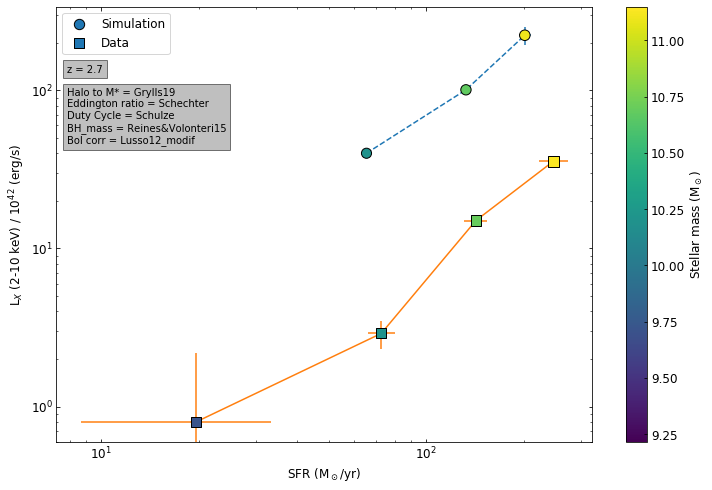

In [18]:
# Plot SFR vs LX
# define parameters for datapoints' colors and colorbar
_min = np.minimum(np.nanmin(bs_perc['stellar_mass',0.5]),np.nanmin(data['m_ave'][0,2:,:]))
_max = np.maximum(np.nanmax(bs_perc['stellar_mass',0.5]),np.nanmax(data['m_ave'][0,2:,:]))

fig = plt.figure(figsize=[12, 8])
#plt.rcParams['figure.figsize'] = [12, 8]

# simulated datapoints
plt.scatter(bs_perc['SFR',0.5],bs_perc['luminosity',0.5], vmin = _min, vmax = _max, edgecolors='Black',
            c=bs_perc['stellar_mass',0.5] , s=bs_perc['stellar_mass',0.5]*10, label='Simulation')
plt.errorbar(bs_perc['SFR',0.5],bs_perc['luminosity',0.5],
                xerr=xerr, yerr=yerr, linestyle='--', zorder=0)

# "real" datapoints
sc=plt.scatter(data['sfr_ave'][0,2:,i], data['l_ave'][0,2:,i], vmin = _min, vmax = _max, edgecolors='Black',
            c=data['m_ave'][0,2:,0], s=data['m_ave'][0,2:,0]*10, marker="s",label='Data')
plt.errorbar(data['sfr_ave'][0,2:,i], data['l_ave'][0,2:,i],
                xerr=[data['sfr_ave'][0,2:,i]-data['sfr_ave'][2,2:,i],
                    data['sfr_ave'][1,2:,i]-data['sfr_ave'][0,2:,i]],
                yerr=np.array([data['l_ave'][0,2:,i] - data['l_ave'][2,2:,i], 
                    data['l_ave'][1,2:,i] - data['l_ave'][0,2:,i]]),
                linestyle='-', zorder=0)

# colorbar, labels, legend, etc
plt.colorbar(sc).set_label('Stellar mass (M$_\odot$)')
text_pars=dict(horizontalalignment='left', verticalalignment='top', bbox=dict(facecolor='gray', alpha=0.5))
plt.text(0.137, 0.78, f'z = {z:.1f}', transform=fig.transFigure, **text_pars)
plt.text(0.137, 0.74, f"Halo to M* = {methods['halo_to_stars']}\nEddington ratio = {methods['edd_ratio']}\nDuty Cycle = {methods['duty_cycle']}\nBH_mass = {methods['BH_mass_method']}\nBol corr = {methods['bol_corr']}", transform=fig.transFigure, **text_pars)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('SFR (M$_\odot$/yr)')
plt.ylabel('L$_X$ (2-10 keV) / $10^{42}$ (erg/s)')
plt.legend(loc='upper left');
plt.savefig(curr_dir+f'/Ros_plots/SFvsLX_z{z}.pdf', format = 'pdf', bbox_inches = 'tight',transparent=True) 

['/Users/Ros/Google_Drive/Valparaiso/LX_SFR_causality/EuclidAGN2/Ros_plots/14_KormendyHo/bs_perc_z1.0.csv', '/Users/Ros/Google_Drive/Valparaiso/LX_SFR_causality/EuclidAGN2/Ros_plots/15_KormendyHo_slope=0.18/bs_perc_z1.0.csv', '/Users/Ros/Google_Drive/Valparaiso/LX_SFR_causality/EuclidAGN2/Ros_plots/16_KormendyHo_slope=0.68/bs_perc_z1.0.csv', '/Users/Ros/Google_Drive/Valparaiso/LX_SFR_causality/EuclidAGN2/Ros_plots/16_KormendyHo_slope=1.50/bs_perc_z1.0.csv']


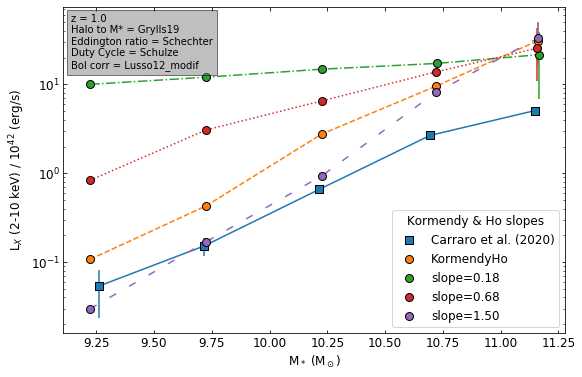

In [19]:
# Comparison of K&H slopes
# define DF path
paths = glob.glob(curr_dir+f'/Ros_plots/1*Kormendy*/bs_perc_z{z}.csv')
paths = sorted(paths)
print(paths)
keys=[p[p.rfind('/')-10:p.rfind('/')] for p in paths]
#read DFs
df_dic = read_dfs(keys,paths)

method_legend=f"Halo to M* = {methods['halo_to_stars']}\nEddington ratio = {methods['edd_ratio']}\nDuty Cycle = {methods['duty_cycle']}\nBol corr = {methods['bol_corr']}"
filename='Comp_K&H_slopes'
leg_title='Kormendy & Ho slopes'
comp_plot(df_dic,method_legend,filename,leg_title=leg_title)

['/Users/Ros/Google_Drive/Valparaiso/LX_SFR_causality/EuclidAGN2/Ros_plots/03_MS_Resubmission_n2/bs_perc_z1.0.csv', '/Users/Ros/Google_Drive/Valparaiso/LX_SFR_causality/EuclidAGN2/Ros_plots/14_KormendyHo/bs_perc_z1.0.csv', '/Users/Ros/Google_Drive/Valparaiso/LX_SFR_causality/EuclidAGN2/Ros_plots/17_BHtoM*_Eq4/bs_perc_z1.0.csv']


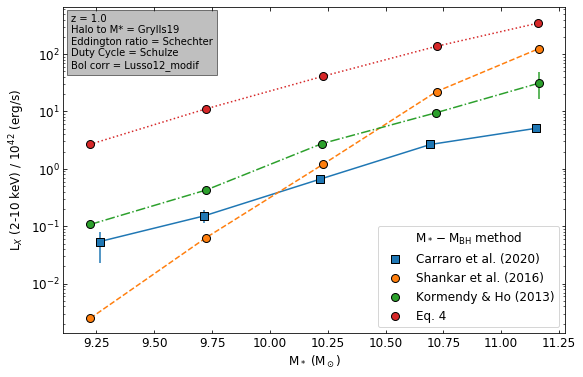

In [20]:
# Comparison of BH_mass_method: K&H, shankar, Eq4
# define DF path
paths = glob.glob(curr_dir+f'/Ros_plots/17*/bs_perc_z{z}.csv') + glob.glob(curr_dir+f'/Ros_plots/14*/bs_perc_z{z}.csv') + glob.glob(curr_dir+f'/Ros_plots/03*/bs_perc_z{z}.csv')
paths = sorted(paths)
print(paths)
keys=['Shankar et al. (2016)','Kormendy & Ho (2013)','Eq. 4']
#read DFs
df_dic = read_dfs(keys,paths)

method_legend=f"Halo to M* = {methods['halo_to_stars']}\nEddington ratio = {methods['edd_ratio']}\nDuty Cycle = {methods['duty_cycle']}\nBol corr = {methods['bol_corr']}"
filename='Comp_BH_mass_method'
leg_title=r'M$_* - {\rm M}_{\rm BH}$ method'
comp_plot(df_dic,method_legend,filename,leg_title=leg_title)

['/Users/Ros/Google_Drive/Valparaiso/LX_SFR_causality/EuclidAGN2/Ros_plots/03_MS_Resubmission_n2/bs_perc_z1.0.csv', '/Users/Ros/Google_Drive/Valparaiso/LX_SFR_causality/EuclidAGN2/Ros_plots/06_Moster/bs_perc_z1.0.csv']


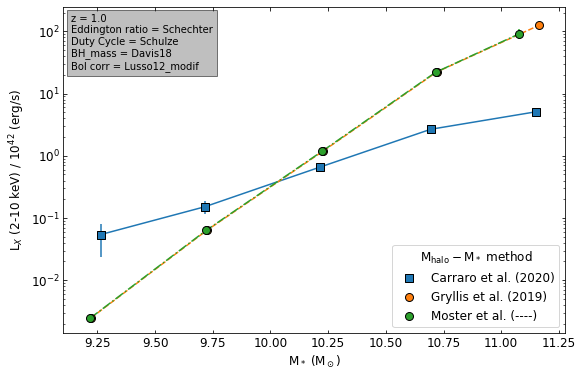

In [21]:
# halo_to_stars comparison
paths = glob.glob(curr_dir+f'/Ros_plots/03*/bs_perc_z{z}.csv') + glob.glob(curr_dir+f'/Ros_plots/06*/bs_perc_z{z}.csv')
paths = sorted(paths)
print(paths)
keys=['Gryllis et al. (2019)','Moster et al. (----)']
#read DFs
df_dic = read_dfs(keys,paths)

method_legend=f"Eddington ratio = {methods['edd_ratio']}\nDuty Cycle = {methods['duty_cycle']}\nBH_mass = {methods['BH_mass_method']}\nBol corr = {methods['bol_corr']}"
filename='Comp_halo_to_stars'
leg_title=r'M$_{\rm halo}-{\rm M}_*$ method'
comp_plot(df_dic,method_legend,filename,leg_title=leg_title)

['/Users/Ros/Google_Drive/Valparaiso/LX_SFR_causality/EuclidAGN2/Ros_plots/03_MS_Resubmission_n2/bs_perc_z1.0.csv', '/Users/Ros/Google_Drive/Valparaiso/LX_SFR_causality/EuclidAGN2/Ros_plots/05_Shankar_DutyCycle0.18/bs_perc_z1.0.csv', '/Users/Ros/Google_Drive/Valparaiso/LX_SFR_causality/EuclidAGN2/Ros_plots/18_DutyCycleMan16/bs_perc_z1.0.csv', '/Users/Ros/Google_Drive/Valparaiso/LX_SFR_causality/EuclidAGN2/Ros_plots/19_DutyCycleGeo/bs_perc_z1.0.csv']


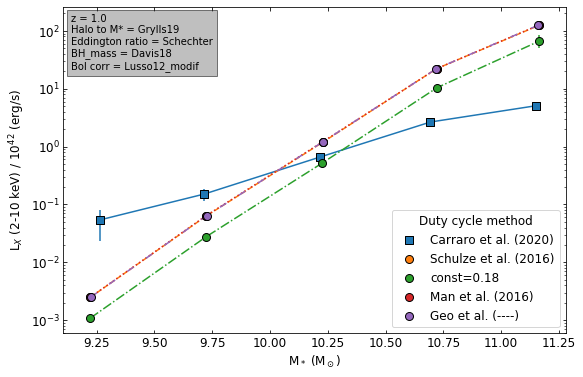

In [22]:
# halo_to_stars comparison
paths = glob.glob(curr_dir+f'/Ros_plots/03*/bs_perc_z{z}.csv') + glob.glob(curr_dir+f'/Ros_plots/*DutyCycle*/bs_perc_z{z}.csv')
paths = sorted(paths)
print(paths)
keys=['Schulze et al. (2016)','const=0.18','Man et al. (2016)','Geo et al. (----)']
#read DFs
df_dic = read_dfs(keys,paths)

method_legend=f"Halo to M* = {methods['halo_to_stars']}\nEddington ratio = {methods['edd_ratio']}\nBH_mass = {methods['BH_mass_method']}\nBol corr = {methods['bol_corr']}"
filename='Comp_duty_cycles'
leg_title=r'Duty cycle method'
comp_plot(df_dic,method_legend,filename,leg_title=leg_title)

['/Users/Ros/Google_Drive/Valparaiso/LX_SFR_causality/EuclidAGN2/Ros_plots/03_MS_Resubmission_n2/bs_perc_z1.0.csv', '/Users/Ros/Google_Drive/Valparaiso/LX_SFR_causality/EuclidAGN2/Ros_plots/07_Gaussian_EddRatio_m=0.25_s=0.05/bs_perc_z1.0.csv', '/Users/Ros/Google_Drive/Valparaiso/LX_SFR_causality/EuclidAGN2/Ros_plots/20_Gaussian_EddRatio_m=0.25_s=0.2/bs_perc_z1.0.csv', '/Users/Ros/Google_Drive/Valparaiso/LX_SFR_causality/EuclidAGN2/Ros_plots/21_Gaussian_EddRatio_m=0.25_s=0.4/bs_perc_z1.0.csv']


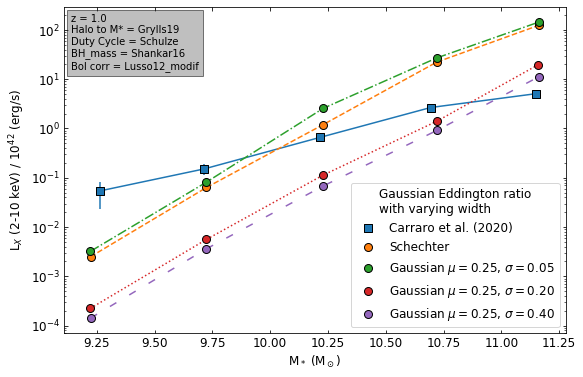

In [49]:
# Gaussian width Edd ratio distributions comparison
paths = glob.glob(curr_dir+f'/Ros_plots/03*/bs_perc_z{z}.csv') + glob.glob(curr_dir+f'/Ros_plots/*Gaussian*m=0.25*/bs_perc_z{z}.csv')
paths = sorted(paths)
print(paths)
keys=['Schechter',r'Gaussian $\mu=0.25$, $\sigma=0.05$',r'Gaussian $\mu=0.25$, $\sigma=0.20$',r'Gaussian $\mu=0.25$, $\sigma=0.40$']
#read DFs
df_dic = read_dfs(keys,paths)

method_legend=f"Halo to M* = {methods['halo_to_stars']}\nDuty Cycle = {methods['duty_cycle']}\nBH_mass = {methods['BH_mass_method']}\nBol corr = {methods['bol_corr']}"
filename='Comp_Edd_gaussian_width'
leg_title='Gaussian Eddington ratio\nwith varying width'
comp_plot(df_dic,method_legend,filename,leg_title=leg_title)

['/Users/Ros/Google_Drive/Valparaiso/LX_SFR_causality/EuclidAGN2/Ros_plots/03_MS_Resubmission_n2/bs_perc_z1.0.csv', '/Users/Ros/Google_Drive/Valparaiso/LX_SFR_causality/EuclidAGN2/Ros_plots/08_Gaussian_EddRatio_m=0.05_s=0.2/bs_perc_z1.0.csv', '/Users/Ros/Google_Drive/Valparaiso/LX_SFR_causality/EuclidAGN2/Ros_plots/20_Gaussian_EddRatio_m=0.25_s=0.2/bs_perc_z1.0.csv', '/Users/Ros/Google_Drive/Valparaiso/LX_SFR_causality/EuclidAGN2/Ros_plots/23_Gaussian_EddRatio_m=0.6_s=0.2/bs_perc_z1.0.csv']


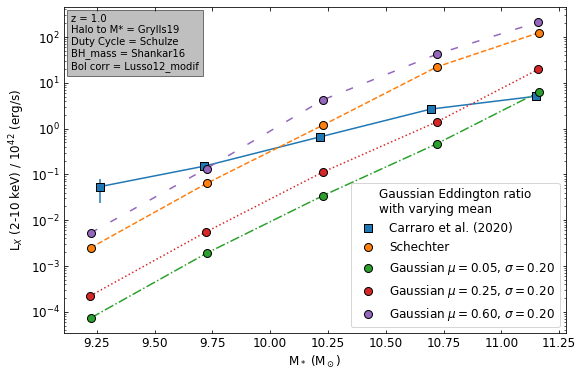

In [50]:
# Gaussian mean Edd ratio distributions comparison
paths = glob.glob(curr_dir+f'/Ros_plots/03*/bs_perc_z{z}.csv') + glob.glob(curr_dir+f'/Ros_plots/*Gaussian*s=0.2*/bs_perc_z{z}.csv')
paths = sorted(paths)
print(paths)
keys=['Schechter',r'Gaussian $\mu=0.05$, $\sigma=0.20$',r'Gaussian $\mu=0.25$, $\sigma=0.20$',r'Gaussian $\mu=0.60$, $\sigma=0.20$']
#read DFs
df_dic = read_dfs(keys,paths)

method_legend=f"Halo to M* = {methods['halo_to_stars']}\nDuty Cycle = {methods['duty_cycle']}\nBH_mass = {methods['BH_mass_method']}\nBol corr = {methods['bol_corr']}"
filename='Comp_Edd_gaussian_mean'
leg_title='Gaussian Eddington ratio\nwith varying mean'
comp_plot(df_dic,method_legend,filename,leg_title=leg_title)